In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
import json
import cv2
import numpy as np
import torch.nn as nn
import torch.nn.functional as F

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
class KeypointsDataset(Dataset):
    def __init__(self, img_dir, data_file):
        self.img_dir = img_dir
        with open(data_file, "r") as f:
            self.data = json.load(f)
        
        self.transforms = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        item = self.data[idx]
        img = cv2.imread(f"{self.img_dir}/{item['id']}.png")
        h,w = img.shape[:2]

        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = self.transforms(img)
        kps = np.array(item['kps']).flatten()
        kps = kps.astype(np.float32)

        kps[::2] *= 224.0 / w
        kps[1::2] *= 224.0 / h

        return img, kps


In [4]:
train_dataset = KeypointsDataset("/kaggle/input/court-keypoints/data/images","/kaggle/input/court-keypoints/data/data_train.json")
val_dataset = KeypointsDataset("/kaggle/input/court-keypoints/data/images","/kaggle/input/court-keypoints/data/data_val.json")

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=True)

In [9]:
class ChannelAttention(nn.Module):
    def __init__(self, in_planes, ratio=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)

        self.fc1 = nn.Conv2d(in_planes, in_planes // ratio, 1, bias=False)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Conv2d(in_planes // ratio, in_planes, 1, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.fc2(self.relu1(self.fc1(self.avg_pool(x))))
        max_out = self.fc2(self.relu1(self.fc1(self.max_pool(x))))
        out = avg_out + max_out
        return self.sigmoid(out)

class SpatialAttention(nn.Module):
    def __init__(self):
        super(SpatialAttention, self).__init__()
        self.conv1 = nn.Conv2d(2, 1, kernel_size=7, padding=3)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x = torch.cat([avg_out, max_out], dim=1)
        x = self.conv1(x)
        return self.sigmoid(x)

class KeypointResNet50(nn.Module):
    def __init__(self):
        super(KeypointResNet50, self).__init__()
        self.backbone = models.resnet50(pretrained=True)
        self.backbone.fc = nn.Identity()

        self.conv = nn.Conv2d(2048, 2048, kernel_size=1, stride=1, padding=0, bias=False)

        self.channel_attention = ChannelAttention(2048)
        self.spatial_attention = SpatialAttention()

        self.fc = nn.Linear(2048, 14 * 2)

    def forward(self, x):
        x = self.backbone(x)
        x = x.unsqueeze(2).unsqueeze(3)
        x = self.conv(x)
        x = self.channel_attention(x) * x
        x = self.spatial_attention(x) * x

        x = nn.functional.adaptive_avg_pool2d(x, (1, 1))
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

In [10]:
model = KeypointResNet50()
model = model.to(device)

In [11]:
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [ ]:
epochs = 20
for epoch in range(epochs):
    model.train()
    for i, (imgs, kps) in enumerate(train_loader):
        imgs = imgs.to(device)
        kps = kps.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, kps)
        loss.backward()
        optimizer.step()

        if i % 10 == 0:
            print(f"Epoch {epoch}, iter {i}, loss: {loss.item()}")

    model.eval()
    with torch.no_grad():
        val_loss = 0
        for imgs, kps in val_loader:
            imgs = imgs.to(device)
            kps = kps.to(device)

            outputs = model(imgs)
            loss = criterion(outputs, kps)
            val_loss += loss.item()

        val_loss /= len(val_loader)
        print(f"Epoch {epoch}, val loss: {val_loss}")

In [16]:
torch.save(model.state_dict(), "keypoints_model.pt")

In [5]:
%ls /kaggle/input/keypoints

keypoints_model.pt


In [2]:
%pwd

'/kaggle/working'

In [20]:
from IPython.display import FileLink
FileLink(r'keypoints_model.pt')

/kaggle/working/keypoints_model.pt

# Evaluate

Test Loss: 5.160125724137475
Test MSE: 5.171186447143555
Test MAE: 0.7092751264572144


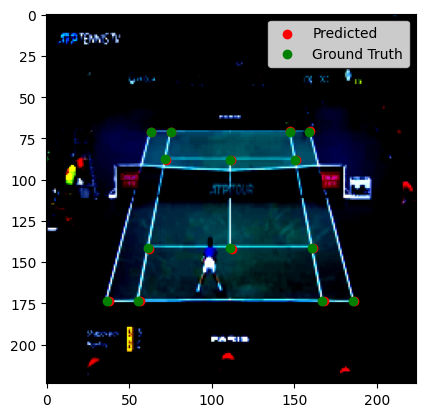

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import json
import cv2
import numpy as np
from torchvision import transforms, models
from torch.utils.data import Dataset
import os
import matplotlib.pyplot as plt

class KeypointsDataset(Dataset):
    def __init__(self, img_dir, data_file):
        self.img_dir = img_dir
        with open(data_file, "r") as f:
            self.data = json.load(f)
        
        self.transforms = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        item = self.data[idx]
        img = cv2.imread(f"{self.img_dir}/{item['id']}.png")
        h, w = img.shape[:2]
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = self.transforms(img)
        kps = np.array(item['kps']).flatten()
        kps = kps.astype(np.float32)
        kps[::2] *= 224.0 / w
        kps[1::2] *= 224.0 / h
        return img, kps

class ChannelAttention(nn.Module):
    def __init__(self, in_planes, ratio=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        self.fc1 = nn.Conv2d(in_planes, in_planes // ratio, 1, bias=False)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Conv2d(in_planes // ratio, in_planes, 1, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.fc2(self.relu1(self.fc1(self.avg_pool(x))))
        max_out = self.fc2(self.relu1(self.fc1(self.max_pool(x))))
        out = avg_out + max_out
        return self.sigmoid(out)

class SpatialAttention(nn.Module):
    def __init__(self):
        super(SpatialAttention, self).__init__()
        self.conv1 = nn.Conv2d(2, 1, kernel_size=7, padding=3)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x = torch.cat([avg_out, max_out], dim=1)
        x = self.conv1(x)
        return self.sigmoid(x)

class KeypointResNet50(nn.Module):
    def __init__(self):
        super(KeypointResNet50, self).__init__()
        self.backbone = models.resnet50(pretrained=True)
        self.backbone.fc = nn.Identity()
        self.conv = nn.Conv2d(2048, 2048, kernel_size=1, stride=1, padding=0, bias=False)
        self.channel_attention = ChannelAttention(2048)
        self.spatial_attention = SpatialAttention()
        self.fc = nn.Linear(2048, 14 * 2)

    def forward(self, x):
        x = self.backbone(x)
        x = x.unsqueeze(2).unsqueeze(3)
        x = self.conv(x)
        x = self.channel_attention(x) * x
        x = self.spatial_attention(x) * x
        x = nn.functional.adaptive_avg_pool2d(x, (1, 1))
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

def evaluate(model, dataloader, device):
    model.eval()
    criterion = nn.MSELoss()
    total_loss = 0
    all_predictions = []
    all_targets = []
    all_images = []
    
    with torch.no_grad():
        for images, targets in dataloader:
            images = images.to(device)
            targets = targets.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, targets)
            total_loss += loss.item()
            
            all_predictions.append(outputs.cpu().numpy())
            all_targets.append(targets.cpu().numpy())
            all_images.append(images.cpu())
    
    avg_loss = total_loss / len(dataloader)
    all_predictions = np.concatenate(all_predictions, axis=0)
    all_targets = np.concatenate(all_targets, axis=0)
    all_images = torch.cat(all_images, dim=0)
    
    return avg_loss, all_predictions, all_targets, all_images

def visualize_predictions(images, predictions, targets, idx=0):
    img = images[idx].permute(1, 2, 0).cpu().numpy()
    pred_kps = predictions[idx].reshape(-1, 2)
    true_kps = targets[idx].reshape(-1, 2)
    
    plt.imshow(img)
    plt.scatter(pred_kps[:, 0], pred_kps[:, 1], color='r', label='Predicted')
    plt.scatter(true_kps[:, 0], true_kps[:, 1], color='g', label='Ground Truth')
    plt.legend()
    plt.show()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = KeypointResNet50().to(device)

# Load the model checkpoint
checkpoint_path = "/kaggle/input/keypoints/keypoints_model.pt"
model.load_state_dict(torch.load(checkpoint_path, map_location=device))

# Create DataLoader for test dataset
test_dataset = KeypointsDataset("/kaggle/input/court-keypoints/data/images","/kaggle/input/court-keypoints/data/data_val.json")
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

# Evaluate the model
test_loss, test_predictions, test_targets, test_images = evaluate(model, test_loader, device)

print(f"Test Loss: {test_loss}")

# Further analysis (optional)
# Calculate MSE, MAE, visualize predictions vs. ground truth, etc.
mse = np.mean((test_predictions - test_targets) ** 2)
mae = np.mean(np.abs(test_predictions - test_targets))

print(f"Test MSE: {mse}")
print(f"Test MAE: {mae}")

visualize_predictions(test_images, test_predictions, test_targets, idx=0)